In [43]:
import pandas as pd
from preprocess.discretization import discretization, get_nodes_type, code_categories, get_nodes_sign
from bayesian.train_bn import structure_learning, parameter_learning
from block_learning.partial_bn_train import connect_partial_bn, hierarchical_train, direct_connect, direct_train, range_pairs
import seaborn as sns
import numpy as np
from copy import  copy
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN, draw_comparative_hist
import networkx as nx
from pomegranate import log_probability, BayesianNetwork
from external.libpgm.sampleaggregator import SampleAggregator
import operator

In [59]:
vk_interes = pd.read_csv('data/vk_interests_finance.csv')
vk_interes.head(10)

,first_name,last_name,sex,age,city_id,has_high_education,relation,num_of_relatives,followers_count,status,...,top3,top3_mean,game_sum,is_gamer,parent_sum,is_parent,driver_sum,is_driver,pets_sum,has_pets
0,Darya,Tsiberkina,1.0,33,2,0,4,2,486,8,...,5812,1277.784568,0.0,0,9968.00,1,0.0,0,0.0,0
1,Gleb,Kotenev,2.0,18,2,0,0,2,0,5,...,5814,384.000000,0.0,0,0.00,0,0.0,0,0.0,0
2,Anna,Pavlova,1.0,34,2,0,0,2,7,0,...,6011,24000.000000,0.0,0,0.00,0,0.0,0,0.0,0
3,Serega,Martynov,2.0,39,2,0,0,2,7,10,...,5411,142.175000,0.0,0,0.00,0,0.0,0,0.0,0
4,Maria,Pavlyukova,1.0,0,2,0,0,2,144,0,...,6011,1095.238095,0.0,0,60331.59,1,0.0,0,80.0,0
5,Yury,Golubkov,2.0,47,2,0,0,2,0,0,...,5964,760.580000,0.0,0,0.00,0,0.0,0,0.0,0
6,Svetlana,Muratova,1.0,48,2,0,4,2,30,0,...,5411,113.000000,0.0,0,0.00,0,0.0,0,0.0,0
7,Ivan,Poletaev,2.0,0,2,0,0,2,53,23,...,5411,446.565263,1000.0,1,0.00,0,0.0,0,0.0,0
8,Anastasia,Yaguzhinskaya,1.0,25,1,0,0,2,111,3,...,5499,185.523529,0.0,0,0.00,0,0.0,0,1287.0,0
9,Valentina,Trokhova,1.0,55,2,0,0,12,56,0,...,5499,345.572472,0.0,0,0.00,0,0.0,0,0.0,0


In [60]:
vk_interes = vk_interes.loc[(vk_interes['age'] != 0) & (vk_interes['age'] <= 90)]

In [61]:
vk_interes.loc[:,'sex'] = vk_interes.loc[:,'sex'].astype('int')
vk_interes.loc[:,'age'] = vk_interes.loc[:,'age'].astype('float')

In [62]:
vk_no_edu = vk_interes.loc[vk_interes['has_high_education'] != 1]

In [63]:
vk_no_edu = vk_no_edu.sample(18000)

In [64]:
vk_edu = vk_interes.loc[vk_interes['has_high_education'] == 1]

In [65]:
vk_final = pd.concat([vk_edu, vk_no_edu])

In [66]:
vk_final.reset_index(inplace=True, drop=True)
vk_final

,first_name,last_name,sex,age,city_id,has_high_education,relation,num_of_relatives,followers_count,status,...,top3,top3_mean,game_sum,is_gamer,parent_sum,is_parent,driver_sum,is_driver,pets_sum,has_pets
0,Sergey,Fedotov,2,50.0,2,1,0,2,3,0,...,4111,92.200000,339.0,1,0.00,0,0.00,0,0.00,0
1,Olga,Smirnova,1,23.0,2,1,4,33,98,0,...,6011,2808.159574,0.0,0,0.00,0,0.00,0,113.00,0
2,Natalia,Gazizova,1,45.0,2,1,0,2,8,0,...,5691,2636.000000,0.0,0,0.00,0,0.00,0,0.00,0
3,Alexey,Zhurikhin,2,43.0,2,1,4,2,11,11,...,5499,224.100795,0.0,0,29327.91,1,0.00,0,30629.00,0
4,Elena,Devyatkina,1,32.0,2,1,4,2,82,7,...,6011,5566.666667,0.0,0,2345.00,1,0.00,0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33288,Tatyana,Sadovnikova,1,63.0,2,0,0,2,260,10,...,5541,1626.609231,0.0,0,0.00,0,0.00,0,4690.00,0
33289,Anatoly,Lomunov,2,55.0,2,0,0,2,111,0,...,5812,940.204483,0.0,0,406.20,1,23499.65,1,6428.50,0
33290,Яков,Никитин,2,72.0,2,0,0,2,22,1,...,6011,14055.555556,0.0,0,0.00,0,0.00,0,7103.95,0
33291,Дмитрий,Саблин,2,35.0,2,0,0,2,0,5,...,6010,16500.000000,0.0,0,0.00,0,0.00,0,0.00,0


In [67]:
vk_base = copy(vk_final[['sex', 'age', 'has_high_education', 'relation', 'платье размер наличие цвет', 'массаж тело   йога',
       'игра команда место', 'цвет цветок букет интерьер',
       'iphone apple торт набор pro чехол',
       'клиент который проект интернет бизнес', 'год война время ссср армия',
       'волос маникюр   ресница', 'handmade ряд ручнаяработа что петля лицо',
       'работа год график день', 'концерт билет музыка рок группа',
       'лечение заболевание кровь врач болезнь',
       'школа искать год вопрос тема', 'кожа лицо масло волос',
       'книга язык слово', 'санкт петербург участие фестиваль май',
       'отдых море   день стоимость', 'магазин цена наличие подарок интернет',
       '  дома ремонт работа это', 'фильм игра серия кино',
       'футбол матч россия сегодня мск зенит',
       'автомобиль добавлять авто машина', 'руб цена рубль продавать размер ',
       'минута добавлять ингредиент соль масло ', 'год театр спектакль кино',
       'фото фотография шоу фотограф свадьба праздник']])

In [68]:
vk_base.dropna(inplace=True)
vk_base.shape

(33291, 30)

In [69]:
vk_base.columns = ['sex', 'age', 'has_high_education', 'relation', 'dress, fashion, color, style', 'massage, meditation, yoga',
       'game, team, competition, sport', 'color, flowers, interior, design',
       'iphone, apple, technology, equipment, smartphone',
       'client, project, internet, business, company', 'war, history, army, politics',
       'beauty, hair, manicure, salon', 'handmade, materials, products',
       'work, schedule, earnings, money', 'music, concerts, rock, tickets, festivals',
       'treatment, doctors, tests, clinic, health',
       'school, education, question, topic', 'skin, face, care, cosmitology',
       'book, reading, language, word, literature', 'St. Petersburg, participation, festival, exhibition',
       'vacation, sea, accommodation, cost', 'shop, price, gifts, internet',
       'home, renovation, decoration, installation', 'film, series, cinema, genre',
       'football, match, russia, team, goalkeeper',
       'car, cars, sale, tires', 'sale, clothes, size, price, sewing',
       'ingredients, cooking, dishes, salt, spices', 'theater, performance, actors',
       'photographer, photography, show, wedding, photographer']

In [70]:
vk_base['top1'] = vk_base[['dress, fashion, color, style', 'massage, meditation, yoga',
       'game, team, competition, sport', 'color, flowers, interior, design',
       'iphone, apple, technology, equipment, smartphone',
       'client, project, internet, business, company', 'war, history, army, politics',
       'beauty, hair, manicure, salon', 'handmade, materials, products',
       'work, schedule, earnings, money', 'music, concerts, rock, tickets, festivals',
       'treatment, doctors, tests, clinic, health',
       'school, education, question, topic', 'skin, face, care, cosmitology',
       'book, reading, language, word, literature', 'St. Petersburg, participation, festival, exhibition',
       'vacation, sea, accommodation, cost', 'shop, price, gifts, internet',
       'home, renovation, decoration, installation', 'film, series, cinema, genre',
       'football, match, russia, team, goalkeeper',
       'car, cars, sale, tires', 'sale, clothes, size, price, sewing',
       'ingredients, cooking, dishes, salt, spices', 'theater, performance, actors',
       'photographer, photography, show, wedding, photographer']].apply(lambda row: row.nlargest(1).index.values[-1],axis=1)

In [71]:
vk_base['top2'] = vk_base[['dress, fashion, color, style', 'massage, meditation, yoga',
       'game, team, competition, sport', 'color, flowers, interior, design',
       'iphone, apple, technology, equipment, smartphone',
       'client, project, internet, business, company', 'war, history, army, politics',
       'beauty, hair, manicure, salon', 'handmade, materials, products',
       'work, schedule, earnings, money', 'music, concerts, rock, tickets, festivals',
       'treatment, doctors, tests, clinic, health',
       'school, education, question, topic', 'skin, face, care, cosmitology',
       'book, reading, language, word, literature', 'St. Petersburg, participation, festival, exhibition',
       'vacation, sea, accommodation, cost', 'shop, price, gifts, internet',
       'home, renovation, decoration, installation', 'film, series, cinema, genre',
       'football, match, russia, team, goalkeeper',
       'car, cars, sale, tires', 'sale, clothes, size, price, sewing',
       'ingredients, cooking, dishes, salt, spices', 'theater, performance, actors',
       'photographer, photography, show, wedding, photographer']].apply(lambda row: row.nlargest(2).index.values[-1],axis=1)

In [72]:
vk_base['top3'] = vk_base[['dress, fashion, color, style', 'massage, meditation, yoga',
       'game, team, competition, sport', 'color, flowers, interior, design',
       'iphone, apple, technology, equipment, smartphone',
       'client, project, internet, business, company', 'war, history, army, politics',
       'beauty, hair, manicure, salon', 'handmade, materials, products',
       'work, schedule, earnings, money', 'music, concerts, rock, tickets, festivals',
       'treatment, doctors, tests, clinic, health',
       'school, education, question, topic', 'skin, face, care, cosmitology',
       'book, reading, language, word, literature', 'St. Petersburg, participation, festival, exhibition',
       'vacation, sea, accommodation, cost', 'shop, price, gifts, internet',
       'home, renovation, decoration, installation', 'film, series, cinema, genre',
       'football, match, russia, team, goalkeeper',
       'car, cars, sale, tires', 'sale, clothes, size, price, sewing',
       'ingredients, cooking, dishes, salt, spices', 'theater, performance, actors',
       'photographer, photography, show, wedding, photographer']].apply(lambda row: row.nlargest(3).index.values[-1],axis=1)

In [73]:
vk_base['top4'] = vk_base[['dress, fashion, color, style', 'massage, meditation, yoga',
       'game, team, competition, sport', 'color, flowers, interior, design',
       'iphone, apple, technology, equipment, smartphone',
       'client, project, internet, business, company', 'war, history, army, politics',
       'beauty, hair, manicure, salon', 'handmade, materials, products',
       'work, schedule, earnings, money', 'music, concerts, rock, tickets, festivals',
       'treatment, doctors, tests, clinic, health',
       'school, education, question, topic', 'skin, face, care, cosmitology',
       'book, reading, language, word, literature', 'St. Petersburg, participation, festival, exhibition',
       'vacation, sea, accommodation, cost', 'shop, price, gifts, internet',
       'home, renovation, decoration, installation', 'film, series, cinema, genre',
       'football, match, russia, team, goalkeeper',
       'car, cars, sale, tires', 'sale, clothes, size, price, sewing',
       'ingredients, cooking, dishes, salt, spices', 'theater, performance, actors',
       'photographer, photography, show, wedding, photographer']].apply(lambda row: row.nlargest(4).index.values[-1],axis=1)

In [74]:
vk_base['top5'] = vk_base[['dress, fashion, color, style', 'massage, meditation, yoga',
       'game, team, competition, sport', 'color, flowers, interior, design',
       'iphone, apple, technology, equipment, smartphone',
       'client, project, internet, business, company', 'war, history, army, politics',
       'beauty, hair, manicure, salon', 'handmade, materials, products',
       'work, schedule, earnings, money', 'music, concerts, rock, tickets, festivals',
       'treatment, doctors, tests, clinic, health',
       'school, education, question, topic', 'skin, face, care, cosmitology',
       'book, reading, language, word, literature', 'St. Petersburg, participation, festival, exhibition',
       'vacation, sea, accommodation, cost', 'shop, price, gifts, internet',
       'home, renovation, decoration, installation', 'film, series, cinema, genre',
       'football, match, russia, team, goalkeeper',
       'car, cars, sale, tires', 'sale, clothes, size, price, sewing',
       'ingredients, cooking, dishes, salt, spices', 'theater, performance, actors',
       'photographer, photography, show, wedding, photographer']].apply(lambda row: row.nlargest(5).index.values[-1],axis=1)

In [75]:
node_types = get_nodes_type(vk_base)
node_types

{'sex': 'disc',
 'age': 'cont',
 'has_high_education': 'disc',
 'relation': 'disc',
 'dress, fashion, color, style': 'cont',
 'massage, meditation, yoga': 'cont',
 'game, team, competition, sport': 'cont',
 'color, flowers, interior, design': 'cont',
 'iphone, apple, technology, equipment, smartphone': 'cont',
 'client, project, internet, business, company': 'cont',
 'war, history, army, politics': 'cont',
 'beauty, hair, manicure, salon': 'cont',
 'handmade, materials, products': 'cont',
 'work, schedule, earnings, money': 'cont',
 'music, concerts, rock, tickets, festivals': 'cont',
 'treatment, doctors, tests, clinic, health': 'cont',
 'school, education, question, topic': 'cont',
 'skin, face, care, cosmitology': 'cont',
 'book, reading, language, word, literature': 'cont',
 'St. Petersburg, participation, festival, exhibition': 'cont',
 'vacation, sea, accommodation, cost': 'cont',
 'shop, price, gifts, internet': 'cont',
 'home, renovation, decoration, installation': 'cont',
 'fi

In [76]:
nodes_sign = get_nodes_sign(vk_base)
nodes_sign

{'age': 'pos',
 'dress, fashion, color, style': 'pos',
 'massage, meditation, yoga': 'pos',
 'game, team, competition, sport': 'pos',
 'color, flowers, interior, design': 'pos',
 'iphone, apple, technology, equipment, smartphone': 'pos',
 'client, project, internet, business, company': 'pos',
 'war, history, army, politics': 'pos',
 'beauty, hair, manicure, salon': 'pos',
 'handmade, materials, products': 'pos',
 'work, schedule, earnings, money': 'pos',
 'music, concerts, rock, tickets, festivals': 'pos',
 'treatment, doctors, tests, clinic, health': 'pos',
 'school, education, question, topic': 'pos',
 'skin, face, care, cosmitology': 'pos',
 'book, reading, language, word, literature': 'pos',
 'St. Petersburg, participation, festival, exhibition': 'pos',
 'vacation, sea, accommodation, cost': 'pos',
 'shop, price, gifts, internet': 'pos',
 'home, renovation, decoration, installation': 'pos',
 'film, series, cinema, genre': 'pos',
 'football, match, russia, team, goalkeeper': 'pos',


In [20]:
top_dict = {'dress, fashion, color, style':0, 
       'massage, meditation, yoga':1,
       'game, team, competition, sport':2, 
       'color, flowers, interior, design':3,
       'iphone, apple, technology, equipment, smartphone':4,
       'client, project, internet, business, company':5, 
       'war, history, army, politics': 6,
       'beauty, hair, manicure, salon': 7, 
       'handmade, materials, products': 8,
       'work, schedule, earnings, money':9, 
       'music, concerts, rock, tickets, festivals':10,
       'treatment, doctors, tests, clinic, health':11,
       'school, education, question, topic':12, 
       'skin, face, care, cosmitology':13,
       'book, reading, language, word, literature':14, 
       'St. Petersburg, participation, festival, exhibition':15,
       'vacation, sea, accommodation, cost':16, 
       'shop, price, gifts, internet':17,
       'home, renovation, decoration, installation':18, 
       'film, series, cinema, genre':19,
       'football, match, russia, team, goalkeeper':20,
       'car, cars, sale, tires':21, 
       'sale, clothes, size, price, sewing':22,
       'ingredients, cooking, dishes, salt, spices':23, 
       'theater, performance, actors':24,
       'photographer, photography, show, wedding, photographer':25}

In [21]:
coded_data = copy(vk_base)
coded_data['top1'] = coded_data['top1'].apply(lambda x: top_dict[x])
coded_data['top2'] = coded_data['top2'].apply(lambda x: top_dict[x])
coded_data['top3'] = coded_data['top3'].apply(lambda x: top_dict[x])
coded_data['top4'] = coded_data['top4'].apply(lambda x: top_dict[x])
coded_data['top5'] = coded_data['top5'].apply(lambda x: top_dict[x])

In [22]:
coded_data

,sex,age,has_high_education,relation,top1,top2,top3,top4,top5
0,2,50.0,1,0,21,6,15,16,24
1,1,23.0,1,4,0,23,6,2,14
2,1,45.0,1,0,9,3,12,15,5
3,2,43.0,1,4,2,15,23,21,17
4,1,32.0,1,4,7,17,25,22,5
...,...,...,...,...,...,...,...,...,...
33288,2,43.0,0,0,19,10,16,15,13
33289,2,39.0,0,0,6,24,11,19,5
33290,2,51.0,0,0,9,10,15,24,14
33291,1,34.0,0,0,7,16,0,17,22


In [23]:
bn_structure = structure_learning(coded_data,'HC', node_types, 'K2')

  0%|          | 14/1000000 [00:02<44:19:35,  6.27it/s]


In [25]:
bn_parameters = parameter_learning(vk_base, node_types, bn_structure)

In [26]:
save_structure(bn_structure, 'bn_structure_new')
skel = read_structure('bn_structure_new')
save_params(bn_parameters, 'bn_params_new')
params = read_params('bn_params_new')
bn = HyBayesianNetwork(skel, params)

In [45]:
sample = generate_synthetics(bn, nodes_sign, 33291)
sample.dropna(inplace=True)
sample.shape

(33291, 9)

In [46]:
sample

,relation,has_high_education,top1,sex,top2,top3,top4,top5,age
0,1,1,"home, renovation, decoration, installation",2,"sale, clothes, size, price, sewing","school, education, question, topic","sale, clothes, size, price, sewing","music, concerts, rock, tickets, festivals",17.756980
1,4,1,"school, education, question, topic",2,"work, schedule, earnings, money","color, flowers, interior, design","car, cars, sale, tires","handmade, materials, products",49.639970
2,0,0,"film, series, cinema, genre",1,"handmade, materials, products","book, reading, language, word, literature","skin, face, care, cosmitology","school, education, question, topic",44.414425
3,0,0,"ingredients, cooking, dishes, salt, spices",1,"St. Petersburg, participation, festival, exhib...","game, team, competition, sport","St. Petersburg, participation, festival, exhib...","handmade, materials, products",31.385692
4,0,0,"car, cars, sale, tires",2,"shop, price, gifts, internet","football, match, russia, team, goalkeeper","home, renovation, decoration, installation","client, project, internet, business, company",27.801382
...,...,...,...,...,...,...,...,...,...
33286,0,1,"film, series, cinema, genre",2,"football, match, russia, team, goalkeeper","client, project, internet, business, company","music, concerts, rock, tickets, festivals","photographer, photography, show, wedding, phot...",37.244361
33287,4,0,"home, renovation, decoration, installation",2,"game, team, competition, sport","St. Petersburg, participation, festival, exhib...","music, concerts, rock, tickets, festivals","car, cars, sale, tires",43.841215
33288,4,1,"car, cars, sale, tires",2,"film, series, cinema, genre","music, concerts, rock, tickets, festivals","music, concerts, rock, tickets, festivals","book, reading, language, word, literature",39.128840
33289,4,0,"St. Petersburg, participation, festival, exhib...",1,"beauty, hair, manicure, salon","war, history, army, politics","dress, fashion, color, style","dress, fashion, color, style",31.055491


In [47]:
sample['relation'] = sample['relation'].apply(lambda x: int(x))
sample['has_high_education'] = sample['has_high_education'].apply(lambda x: int(x))
sample['sex'] = sample['sex'].apply(lambda x: int(x))

In [48]:
sample['age'] = sample['age'].apply(lambda x: int(x))

In [49]:
sample['top1'] = sample['top1'].apply(lambda x: str(x))
sample['top2'] = sample['top2'].apply(lambda x: str(x))
sample['top3'] = sample['top3'].apply(lambda x: str(x))
sample['top4'] = sample['top4'].apply(lambda x: str(x))
sample['top5'] = sample['top5'].apply(lambda x: str(x))

In [50]:
coded_data['top1'] = coded_data['top1'].apply(lambda x: str(x))
coded_data['top2'] = coded_data['top2'].apply(lambda x: str(x))
coded_data['top3'] = coded_data['top3'].apply(lambda x: str(x))
coded_data['top4'] = coded_data['top4'].apply(lambda x: str(x))
coded_data['top5'] = coded_data['top5'].apply(lambda x: str(x))

In [51]:
all_data = copy(sample)
all_data['label'] = ['Synthetic' for i in range(sample.shape[0])]

In [52]:
vk_base['label'] = ['Real' for i in range(vk_base.shape[0])]

In [53]:
all_data = pd.concat([all_data, vk_base])

In [54]:
all_data = all_data.sample(frac=1).reset_index(drop=True)

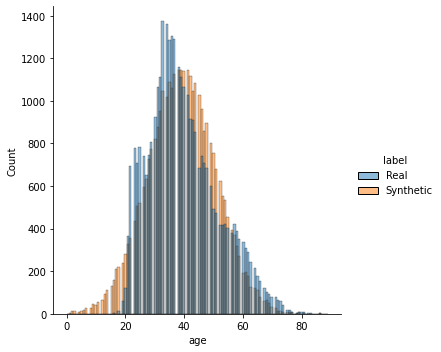

In [55]:
sns.displot(data=all_data, x='age', hue='label')

(array([ 0,  5, 10, 15, 20, 25]),
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20'),
  Text(25, 0, '25')])

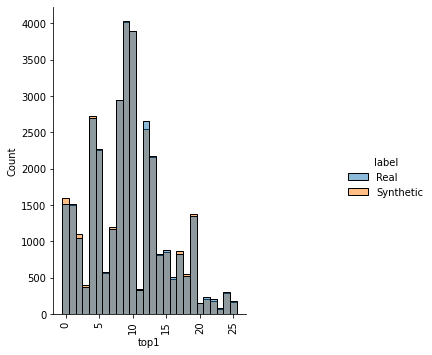

In [56]:
sns.displot(data=all_data, x='top1', hue='label')
positions = ([i for i in range(0,26,5)])
labels = ([str(i) for i in range(0,26,5)])
plt.xticks(positions, labels)
plt.xticks(rotation=90)

In [77]:
data = vk_base[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives','len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies','top1','top2','top3','top4', 'nodes',	'betweenness_centrality',	'density',	'eigenvector_centrality',	'degree_assortativity_coefficient','max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']] #'posts_count',	'posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']]

KeyError: "['number_of_relatives', 'nodes', 'betweenness_centrality', 'degree_assortativity_coefficient', 'mean_tr', 'number_of_books', 'relation_status', 'cash_usage', 'number_of_movies', 'number_of_activities', 'eigenvector_centrality', 'parent', 'number_of_interests', 'driver', 'len_of_about', 'has_pets', 'max_tr', 'density'] not in index"

In [4]:
data.shape

(51478, 25)

In [4]:
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [6]:
data.shape

(51371, 25)

In [5]:
discrete_data = code_categories(data, ['top1', 'top2', 'top3', 'top4'])

In [6]:
new_data = discretization(discrete_data , 'equal_frequency', bins= 5, columns=['betweenness_centrality',	'density',	'eigenvector_centrality',	'degree_assortativity_coefficient','max_tr', 'mean_tr'])#, 'posts_per_month', 'repost_ratio'])

In [7]:
module1 = new_data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives']]
module2 = new_data[['len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies']]
module3 = new_data[['top1', 'top2', 'top3', 'top4']]
module4 = new_data[['nodes',	'betweenness_centrality',	'eigenvector_centrality', 'density', 'degree_assortativity_coefficient']]
module5 = new_data[['max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']]
#module6 = new_data[['posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']]

In [8]:
node_type1 = get_nodes_type(data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives']])
node_type1

{'age': 'disc',
 'sex': 'disc',
 'has_high_education': 'disc',
 'relation_status': 'disc',
 'number_of_relatives': 'disc'}

In [9]:
node_type2 = get_nodes_type(data[['len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies']])
node_type2

{'len_of_about': 'disc',
 'number_of_activities': 'disc',
 'number_of_books': 'disc',
 'number_of_interests': 'disc',
 'number_of_movies': 'disc'}

In [10]:
node_type3 = get_nodes_type(data[['top1', 'top2', 'top3', 'top4']])
node_type3

{'top1': 'disc', 'top2': 'disc', 'top3': 'disc', 'top4': 'disc'}

In [11]:
node_type4 = get_nodes_type(data[['nodes',	'betweenness_centrality',	'eigenvector_centrality', 'density', 'degree_assortativity_coefficient']])
node_type4

{'nodes': 'disc',
 'betweenness_centrality': 'cont',
 'eigenvector_centrality': 'cont',
 'density': 'cont',
 'degree_assortativity_coefficient': 'cont'}

In [12]:
node_type5 = get_nodes_type(data[['max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']])
node_type5

{'max_tr': 'cont',
 'mean_tr': 'cont',
 'parent': 'disc',
 'driver': 'disc',
 'has_pets': 'disc',
 'cash_usage': 'disc'}

In [15]:
#node_type6 = get_nodes_type(data[['posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']])
#node_type6

In [15]:
# start = time.time()
# node_type = {**node_type1, **node_type2, **node_type3, **node_type4, **node_type5}
# bn = structure_learning(new_data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives','len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies','top1', 'top2', 'top3', 'top4','nodes',	'betweenness_centrality',	'eigenvector_centrality', 'density', 'degree_assortativity_coefficient', 'max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']], 'K2', node_type)
# param = parameter_learning(data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives','len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies','top1', 'top2', 'top3', 'top4','nodes',	'betweenness_centrality',	'eigenvector_centrality', 'density', 'degree_assortativity_coefficient','max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']], node_type, bn)
# end = time.time()
# print(end - start)

  0%|          | 0/1000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
# save_structure(bn, 'full_net')
# skel = read_structure('full_net')
# save_params(param, 'full_net_param')
# params = read_params('full_net_param')
# full = HyBayesianNetwork(skel, params)

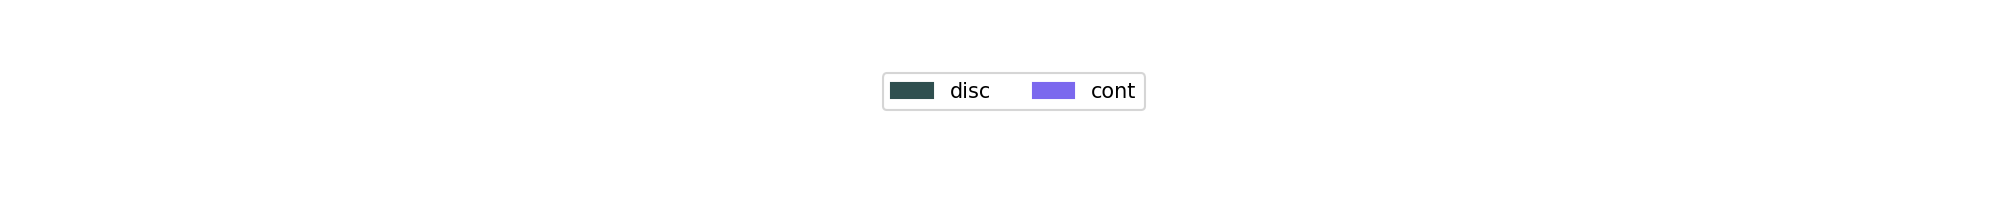

In [18]:
#draw_BN(bn, node_type, 'Full_net')

In [13]:
start = time.time()
bn1 = structure_learning(module1, 'K2', node_type1)

  0%|          | 4/1000000 [00:00<30:37:52,  9.07it/s]


In [15]:
bn1

{'V': ['age',
  'sex',
  'has_high_education',
  'relation_status',
  'number_of_relatives'],
 'E': [['age', 'sex'],
  ['has_high_education', 'number_of_relatives'],
  ['has_high_education', 'age'],
  ['relation_status', 'has_high_education'],
  ['relation_status', 'age']]}

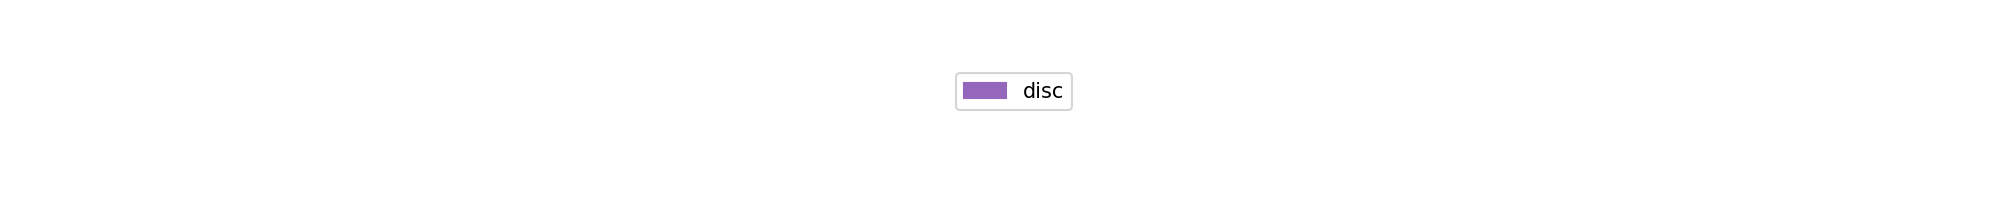

In [26]:
draw_BN(bn1, node_type1, 'module1')

In [10]:
param1 = parameter_learning(data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives']], node_type1, bn1)

In [11]:
save_structure(bn1, 'skel1')
skel1 = read_structure('skel1')
save_params(param1, 'params1')
params1 = read_params('params1')
hybn1 = HyBayesianNetwork(skel1, params1)

In [14]:
bn2 = structure_learning(module2, 'K2', node_type2)

  0%|          | 3/1000000 [00:00<53:04:09,  5.23it/s]


In [31]:
bn2

{'V': ['len_of_about',
  'number_of_activities',
  'number_of_books',
  'number_of_interests',
  'number_of_movies'],
 'E': [['number_of_activities', 'number_of_interests'],
  ['number_of_activities', 'len_of_about'],
  ['number_of_interests', 'number_of_movies'],
  ['number_of_movies', 'number_of_books']]}

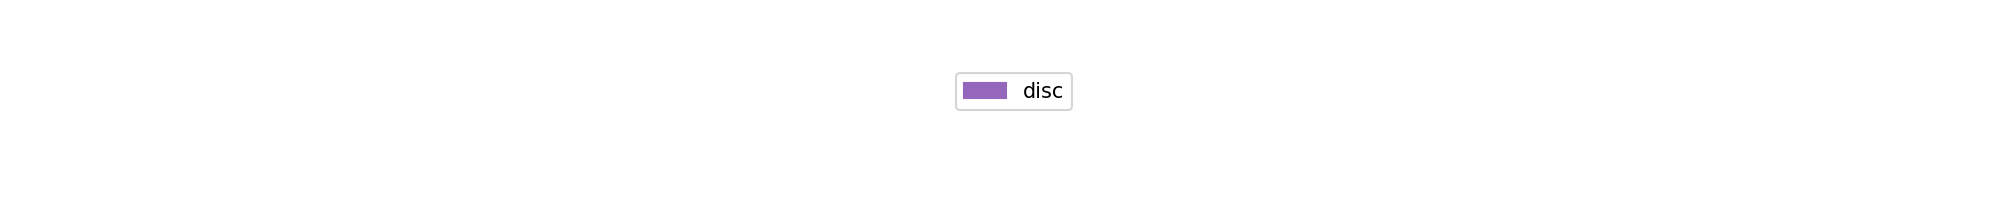

In [32]:
draw_BN(bn2, node_type2, 'module2')

In [33]:
#param2 = parameter_learning(data[['len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies']], node_type2, bn2)

In [34]:
# save_structure(bn2, 'skel2')
# skel2 = read_structure('skel2')
# save_params(param2, 'params2')
# params2 = read_params('params2')
# hybn2 = HyBayesianNetwork(skel2, params2)


In [35]:
end = time.time()
print(end - start)

2.421198844909668


In [36]:
# node_type_final = {**node_type1, **node_type2}
# hybn_connect = direct_connect([bn1,bn2],new_data, node_type_final)
# hybn_final = direct_train([bn1,bn2], data, hybn_connect)

In [37]:
# end = time.time()
# print(end - start)

In [15]:
bn3 = structure_learning(module3, 'K2', node_type3)
bn3

  0%|          | 6/1000000 [00:00<13:56:21, 19.93it/s]


{'V': ['top1', 'top2', 'top3', 'top4'],
 'E': [['top1', 'top2'],
  ['top1', 'top4'],
  ['top1', 'top3'],
  ['top2', 'top4'],
  ['top2', 'top3'],
  ['top3', 'top4']]}

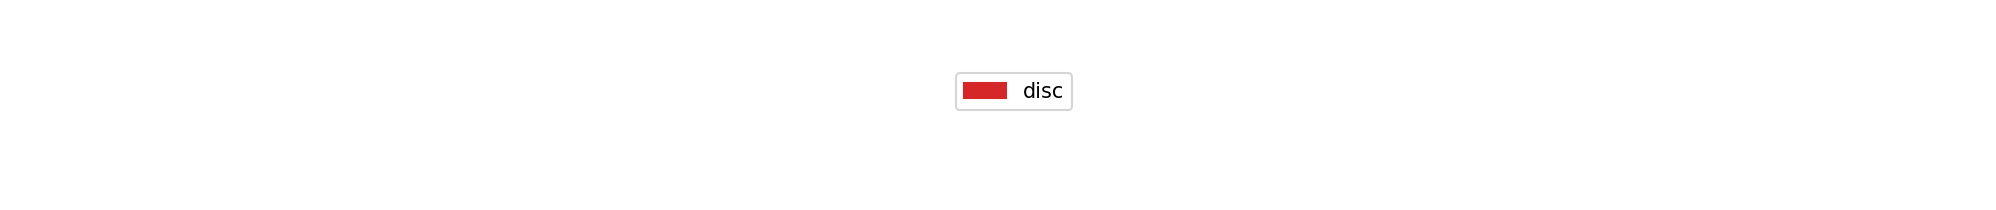

In [39]:
draw_BN(bn3, node_type3, 'module3')

In [40]:
#param3 = parameter_learning(data[['top1', 'top2', 'top3', 'top4']], node_type3, bn3)

In [41]:
# save_structure(bn3, 'skel3')
# skel3 = read_structure('skel3')
# save_params(param3, 'params3')
# params3 = read_params('params3')
# hybn3 = HyBayesianNetwork(skel3, params3)

In [42]:
end = time.time()
print(end - start)

3.4464473724365234


In [43]:
# node_type_final = {**node_type1, **node_type2,  **node_type3}
# hybn_connect = direct_connect([bn1,bn2, bn3],new_data, node_type_final)
# hybn_final = direct_train([bn1,bn2, bn3], data, hybn_connect)

In [44]:
# end = time.time()
# print(end - start)

In [16]:
bn4 = structure_learning(module4, 'K2', node_type4)
bn4

  0%|          | 5/1000000 [00:00<47:14:02,  5.88it/s]


{'V': ['nodes',
  'betweenness_centrality',
  'eigenvector_centrality',
  'density',
  'degree_assortativity_coefficient'],
 'E': [['nodes', 'degree_assortativity_coefficient'],
  ['nodes', 'density'],
  ['betweenness_centrality', 'density'],
  ['eigenvector_centrality', 'betweenness_centrality'],
  ['degree_assortativity_coefficient', 'eigenvector_centrality'],
  ['degree_assortativity_coefficient', 'betweenness_centrality']]}

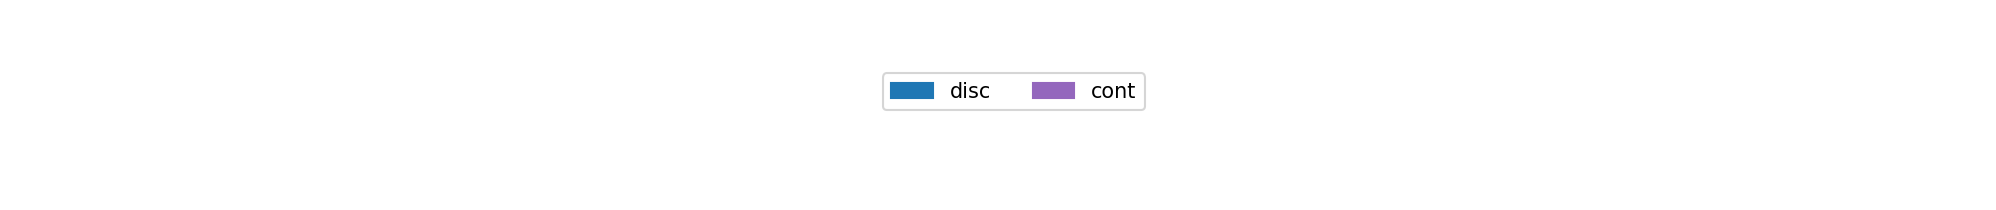

In [46]:
draw_BN(bn4, node_type4, 'module4')

In [24]:
param4 = parameter_learning(data[['nodes',	'betweenness_centrality',	'eigenvector_centrality', 'density', 'degree_assortativity_coefficient']], node_type4, bn4)

In [25]:
save_structure(bn4, 'skel4')
skel4 = read_structure('skel4')
save_params(param4, 'params4')
params4 = read_params('params4')
hybn4 = HyBayesianNetwork(skel4, params4)

In [49]:
end = time.time()
print(end - start)

5.370755910873413


In [50]:
# node_type_final = {**node_type1, **node_type2,  **node_type3, **node_type4}
# hybn_connect = direct_connect([bn1,bn2, bn3, bn4],new_data, node_type_final)
# hybn_final = direct_train([bn1,bn2, bn3, bn4], data, hybn_connect)

In [51]:
# end = time.time()
# print(end - start)

In [17]:
bn5 = structure_learning(module5, 'K2', node_type5)

  0%|          | 17/1000000 [00:00<15:24:44, 18.02it/s]


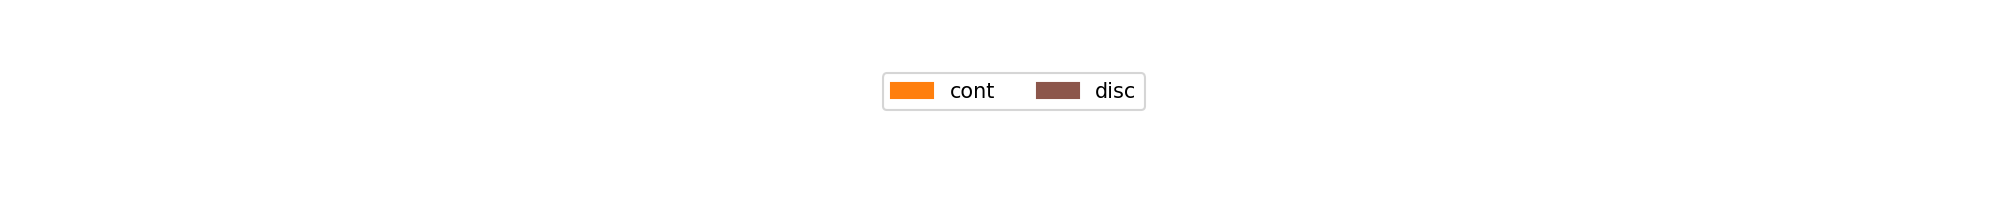

In [53]:
draw_BN(bn5, node_type5, 'module5')

In [54]:
#param5 = parameter_learning(data[['max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']], node_type5, bn5)

In [55]:
# save_structure(bn5, 'skel5')
# skel5 = read_structure('skel5')
# save_params(param5, 'params5')
# params5 = read_params('params5')
# hybn5 = HyBayesianNetwork(skel5, params5)

In [56]:
end = time.time()
print(end - start)

6.8917975425720215


In [57]:
# bn6 = structure_learning(module6, 'K2', node_type6)
# bn6

In [58]:
#param6 = parameter_learning(data[['posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']], node_type6, bn6)

In [59]:
# save_structure(bn6, 'skel6')
# skel6 = read_structure('skel6')
# save_params(param6, 'params6')
# params6 = read_params('params6')
# hybn6 = HyBayesianNetwork(skel6, params6)

In [19]:
range_pairs([bn1, bn2, bn3, bn4, bn5], new_data)

{'V1_4': -352834.0440068238,
 'V4_1': -353640.1657624417,
 'V1_0': -410577.7469005451,
 'V0_1': -415241.3285898874,
 'V1_2': -434420.840095207,
 'V2_1': -435049.5492549512,
 'V0_4': -554346.5770650896,
 'V4_0': -554370.0593511226,
 'V4_2': -564045.8306341865,
 'V2_4': -564290.12640823,
 'V0_2': -631718.7328187228,
 'V2_0': -635438.9882819874,
 'V3_1': -673862.6250667105,
 'V1_3': -679858.7204833858,
 'V3_4': -804513.3633462528,
 'V4_3': -813995.0091491337,
 'V3_0': -875265.0019050431,
 'V3_2': -884673.0082250253,
 'V0_3': -885407.7636505233,
 'V2_3': -898997.3520367616}

In [60]:
node_type_final = {**node_type1, **node_type2, **node_type3, **node_type4, **node_type5}

In [61]:
hybn_connect = direct_connect([bn1,bn2, bn3, bn4, bn5],new_data, node_type_final)




  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 1/1000000 [00:15<4282:12:26, 15.42s/it]

  0%|          | 2/1000000 [00:16<2260:26:15,  8.14s/it]

  0%|          | 3/1000000 [00:16<1571:30:37,  5.66s/it]

  0%|          | 4/1000000 [00:17<1221:29:22,  4.40s/it]

  0%|          | 5/1000000 [00:18<1011:35:18,  3.64s/it]

  0%|          | 6/1000000 [00:19<883:38:51,  3.18s/it] 

  0%|          | 7/1000000 [00:20<795:42:53,  2.86s/it]

  0%|          | 8/1000000 [00:20<719:16:34,  2.59s/it]

  0%|          | 9/1000000 [00:21<661:12:48,  2.38s/it]

  0%|          | 10/1000000 [00:22<613:29:05,  2.21s/it]

  0%|          | 11/1000000 [00:22<574:26:03,  2.07s/it]

  0%|          | 12/1000000 [00:23<551:53:40,  1.99s/it]

  0%|          | 13/1000000 [00:24<522:04:18,  1.88s/it]

  0%|          | 14/1000000 [00:25<506:50:57,  1.82s/it]

  0%|          | 15/1000000 [00:26<493:51:36,  1.78s/it]

  0%|          | 16/1000000 [00:27<484:14:55,  1.74s/it]

  0%|          | 17/1000000 

In [62]:
hybns = [bn1,bn2, bn3, bn4, bn5]

In [63]:
hybn_final = direct_train(hybns, data, hybn_connect)

0 1
0 2
0 3
0 4
1 3
4 2
3 2


In [64]:
sample = pd.DataFrame()

In [65]:
for i in range (1000):
    age = np.random.randint(50,71,1)[0]
    evidence = {'age':str(age), 'sex':'1'}
    batch = pd.DataFrame(hybn_final.randomsample(5,evidence))
    sample = pd.concat([sample,batch])

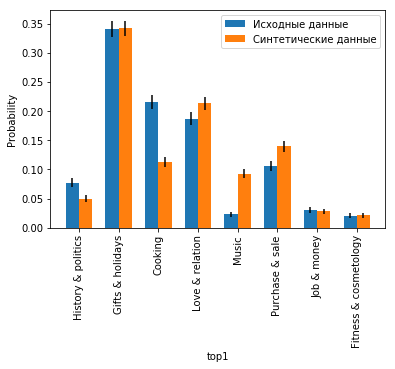

In [66]:
draw_comparative_hist('top1', data_filter, sample)

In [67]:
end = time.time()
print(end - start)

220.57396340370178


In [68]:
final_struct = dict()
final_struct['V'] = hybn_final.V
final_struct['E'] = hybn_final.E

In [69]:
final_struct['V'] 

['relation_status',
 'has_high_education',
 'number_of_relatives',
 'age',
 'sex',
 'L 0_1',
 'number_of_activities',
 'number_of_interests',
 'number_of_movies',
 'number_of_books',
 'len_of_about',
 'L 1_3',
 'L 0_2',
 'L 0_4',
 'cash_usage',
 'parent',
 'driver',
 'has_pets',
 'L 4_2',
 'mean_tr',
 'max_tr',
 'L 0_3',
 'nodes',
 'L 3_2',
 'top1',
 'top2',
 'top3',
 'top4',
 'degree_assortativity_coefficient',
 'eigenvector_centrality',
 'betweenness_centrality',
 'density']

In [70]:
final_struct['E']

[['top1', 'top3'],
 ['driver', 'max_tr'],
 ['number_of_movies', 'number_of_books'],
 ['number_of_activities', 'number_of_interests'],
 ['number_of_relatives', 'L 0_3'],
 ['eigenvector_centrality', 'betweenness_centrality'],
 ['has_pets', 'L 4_2'],
 ['cash_usage', 'mean_tr'],
 ['number_of_relatives', 'L 0_2'],
 ['nodes', 'L 3_2'],
 ['mean_tr', 'max_tr'],
 ['nodes', 'density'],
 ['L 0_1', 'number_of_activities'],
 ['parent', 'max_tr'],
 ['top3', 'top4'],
 ['L 0_2', 'top1'],
 ['top2', 'top3'],
 ['parent', 'driver'],
 ['L 4_2', 'top1'],
 ['sex', 'L 0_1'],
 ['sex', 'L 0_2'],
 ['number_of_relatives', 'L 0_4'],
 ['nodes', 'degree_assortativity_coefficient'],
 ['has_pets', 'mean_tr'],
 ['degree_assortativity_coefficient', 'betweenness_centrality'],
 ['cash_usage', 'driver'],
 ['top1', 'top2'],
 ['number_of_relatives', 'L 0_1'],
 ['has_high_education', 'number_of_relatives'],
 ['sex', 'L 0_4'],
 ['parent', 'has_pets'],
 ['parent', 'L 4_2'],
 ['top2', 'top4'],
 ['age', 'sex'],
 ['cash_usage', 'p

In [71]:
node_type_final['L 0_1'] = 'disc'
node_type_final['L 0_3'] = 'disc'
node_type_final['L 0_4'] = 'disc'
node_type_final['L 0_2'] = 'disc'
node_type_final['L 2_4'] = 'disc'
node_type_final['L 2_0'] = 'disc'
node_type_final['L 4_2'] = 'disc'
node_type_final['L 3_0'] = 'disc'
node_type_final['L 1_0'] = 'disc'
node_type_final['L 1_3'] = 'disc'
node_type_final['L 3_2'] = 'disc'

In [72]:
node_type_final

{'age': 'disc',
 'sex': 'disc',
 'has_high_education': 'disc',
 'relation_status': 'disc',
 'number_of_relatives': 'disc',
 'len_of_about': 'disc',
 'number_of_activities': 'disc',
 'number_of_books': 'disc',
 'number_of_interests': 'disc',
 'number_of_movies': 'disc',
 'top1': 'disc',
 'top2': 'disc',
 'top3': 'disc',
 'top4': 'disc',
 'nodes': 'disc',
 'betweenness_centrality': 'cont',
 'eigenvector_centrality': 'cont',
 'density': 'cont',
 'degree_assortativity_coefficient': 'cont',
 'max_tr': 'cont',
 'mean_tr': 'cont',
 'parent': 'disc',
 'driver': 'disc',
 'has_pets': 'disc',
 'cash_usage': 'disc',
 'L 0_1': 'disc',
 'L 0_3': 'disc',
 'L 0_4': 'disc',
 'L 0_2': 'disc',
 'L 2_4': 'disc',
 'L 2_0': 'disc',
 'L 4_2': 'disc',
 'L 3_0': 'disc',
 'L 1_0': 'disc',
 'L 1_3': 'disc',
 'L 3_2': 'disc'}

In [76]:
final_struct

{'V': ['relation_status',
  'has_high_education',
  'number_of_relatives',
  'age',
  'sex',
  'L 0_1',
  'number_of_activities',
  'number_of_interests',
  'number_of_movies',
  'number_of_books',
  'len_of_about',
  'L 1_3',
  'L 0_2',
  'L 0_4',
  'cash_usage',
  'parent',
  'driver',
  'has_pets',
  'L 4_2',
  'mean_tr',
  'max_tr',
  'L 0_3',
  'nodes',
  'L 3_2',
  'top1',
  'top2',
  'top3',
  'top4',
  'degree_assortativity_coefficient',
  'eigenvector_centrality',
  'betweenness_centrality',
  'density'],
 'E': [['top1', 'top3'],
  ['driver', 'max_tr'],
  ['number_of_movies', 'number_of_books'],
  ['number_of_activities', 'number_of_interests'],
  ['number_of_relatives', 'L 0_3'],
  ['eigenvector_centrality', 'betweenness_centrality'],
  ['has_pets', 'L 4_2'],
  ['cash_usage', 'mean_tr'],
  ['number_of_relatives', 'L 0_2'],
  ['nodes', 'L 3_2'],
  ['mean_tr', 'max_tr'],
  ['nodes', 'density'],
  ['L 0_1', 'number_of_activities'],
  ['parent', 'max_tr'],
  ['top3', 'top4'],
  [

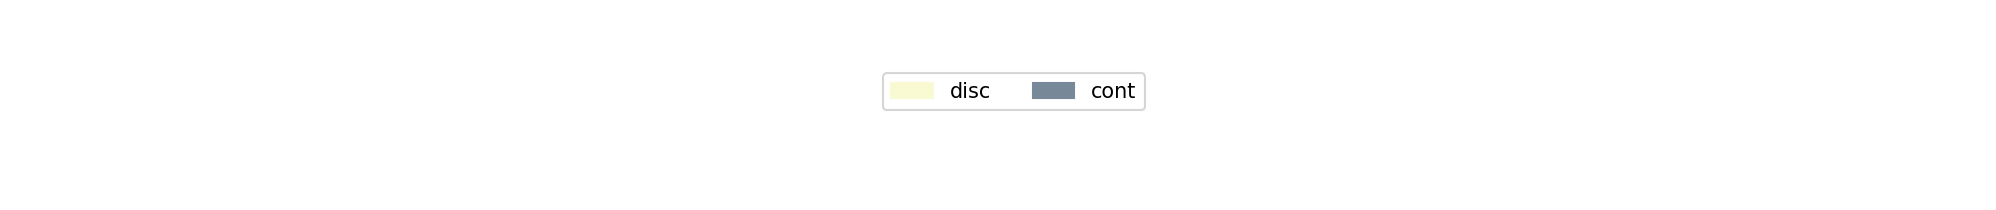

In [75]:
visualizer(final_struct, node_type_final, 'final_net')